In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import tikzplotlib
from qiskit import Aer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.circuit.library import EfficientSU2
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer import QasmSimulator, AerProvider
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import *

In [22]:
plt.rcParams["figure.dpi"] = 100
plt.style.use("seaborn")

In [5]:
basis_sets = ['sto3g', '631g', 'ccpvdz']
threshold = 0.00000001
aqua_globals.random_seed = 500

In [6]:
def get_qubit_hamiltonian(d, basis_set, map_type='jordan_wigner'):
    """
    Obtain the qubit operators from the fermionic operators after second quantization.
    Args:
        d: inter-atomic distance
        basis_set: computational chemistry basis set
        map_type: encoding method

    Returns: qubit Hamiltonian as a weighted summed of Paulis, energy shift because of nuclear repulsion, number of particles and number of spin orbitals

    """
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(d) ,
                         unit=UnitsType.ANGSTROM,
                         charge=0,
                         spin=0,
                         basis=basis_set)
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    repulsion_energy = molecule.nuclear_repulsion_energy
    fermionic_op = FermionicOperator(h1,h2)
    qubit_op = fermionic_op.mapping(map_type=map_type, threshold=threshold)
    return qubit_op, repulsion_energy, num_particles, num_spin_orbitals

In [7]:
qubit_ops = {}
for set in basis_sets:
    qubit_ops["qubitOp_{0}".format(set)],_,_,_ = get_qubit_hamiltonian(0.735, set)

for label in qubit_ops:
    print("\n --- {} ---".format(label),qubit_ops[label])



 --- qubitOp_sto3g --- Representation: paulis, qubits: 4, size: 15

 --- qubitOp_631g --- Representation: paulis, qubits: 8, size: 185

 --- qubitOp_ccpvdz --- Representation: paulis, qubits: 20, size: 2951


In [8]:
bond_lengths = np.linspace(0.1, 3.5, 30)

In [9]:
devices = ["fake_valencia", "fake_valencia_with_mitigation"]

In [10]:
def construct_qinstance(device):
    """
    Create a quantum instance with required backend properties including noise models

    Args:
        device:  high performance simulator backend to be used
            qasm_simulator : ideal multi-shot execution of qiskit circuits and returns counts or memory
            fake_valencia : simulation of an actual device - Valencia backend
            fake_valencia_with_mitigation : simulation of an actual device - Valencia backend with error mitigation applied

    Returns: QuantumInstance obj

    """
    simulator_backend = Aer.get_backend('qasm_simulator')

    device_backend = FakeValencia()
    qubit_connectivity = device_backend.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device_backend)

    if device == "qasm_ideal":
        qinstance = QuantumInstance(backend=simulator_backend,
                                    seed_simulator=aqua_globals.random_seed)

    elif device == "fake_valencia":
        simulator = QasmSimulator(provider=AerProvider(), method='density_matrix')
        qinstance = QuantumInstance(backend=simulator,
                                    noise_model=noise_model,
                                    coupling_map=qubit_connectivity,
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed)

    elif device == "fake_valencia_with_mitigation":
        simulator = QasmSimulator(provider=AerProvider(), method='density_matrix')
        qinstance = QuantumInstance(backend=simulator,
                                    seed_simulator=aqua_globals.random_seed,
                                    seed_transpiler=aqua_globals.random_seed,
                                    noise_model=noise_model,
                                    measurement_error_mitigation_cls=CompleteMeasFitter,
                                    cals_matrix_refresh_period=30)
    return qinstance

In [11]:
exact_energies = []

vqe_energies_effSU2 = []
vqe_energies_uccsd = []
vqe_energies_effSU2_fake = []
vqe_energies_effSU2_fake_mit = []


counts_effSU2 = []
values_effSU2 = []
counts_effSU2_fake = []
values_effSU2_fake = []
counts_effSU2_fake_mit = []
values_effSU2_fake_mit = []

counts_uccsd = []
values_uccsd = []

In [12]:
def store_intermediate_result_uccsd(eval_count, parameters, mean, std):
    """
    Callback function for VQE that enables storange of intermediate values
    Args:
        eval_count: number of evaluations for convergence
        parameters: variational paratmeters
        mean: mean value
        std: standard deviation

    Returns:
        counts, mean

    """
    counts_uccsd.append(eval_count)
    values_uccsd.append(mean)
    return counts_uccsd, values_uccsd

def store_intermediate_result_effSU2(eval_count, parameters, mean, std):
    counts_effSU2.append(eval_count)
    values_effSU2.append(mean)
    return counts_effSU2, values_effSU2

def store_intermediate_result_effSU2_fake(eval_count, parameters, mean, std):
    counts_effSU2_fake.append(eval_count)
    values_effSU2_fake.append(mean)
    return counts_effSU2_fake, values_effSU2_fake

def store_intermediate_result_effSU2_fake_mit(eval_count, parameters, mean, std):
    counts_effSU2_fake_mit.append(eval_count)
    values_effSU2_fake_mit.append(mean)
    return counts_effSU2_fake_mit, values_effSU2_fake_mit

In [13]:
for dist in bond_lengths:
    qubitOp, shift, num_particles, num_spin_orbitals = get_qubit_hamiltonian(dist,basis_set='sto3g')
    result = NumPyEigensolver(qubitOp).run()
    exact_energy = np.real(result.eigenvalues) + shift
    exact_energies.append(exact_energy) 
    initial_state = HartreeFock(num_spin_orbitals,
                                num_particles,
                                two_qubit_reduction=False,
                                qubit_mapping='jordan_wigner')
    optimizer = SPSA(maxiter=200)

    ansatz = [UCCSD(num_orbitals= num_spin_orbitals,
                    num_particles= num_particles,
                    initial_state= initial_state,
                    qubit_mapping='jordan_wigner',
                    two_qubit_reduction=False,),
              EfficientSU2(num_qubits=qubitOp.num_qubits,
                           su2_gates=['rz','rx','rz'],
                           initial_state=Zero(qubitOp.num_qubits))]
    for psi in ansatz:
        if psi == ansatz[0]:
            print("----UCCSD----")
            vqe = VQE(qubitOp, psi, optimizer, callback=store_intermediate_result_uccsd)
            vqe_result = np.real(vqe.run(construct_qinstance('qasm_ideal'))['eigenvalue'] + shift)
            vqe_energies_uccsd.append(vqe_result)
            print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result)

        elif psi == ansatz[1]:
            print("----Hardware Efficient Ansatz----")
            vqe = VQE(qubitOp, psi, optimizer, callback=store_intermediate_result_effSU2)
            vqe_result = np.real(vqe.run(construct_qinstance('qasm_ideal'))['eigenvalue'] + shift)
            vqe_energies_effSU2.append(vqe_result)
            print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result)

            for device in devices:
                if device == "fake_valencia":
                    vqe = VQE(qubitOp, psi, optimizer, callback=store_intermediate_result_effSU2_fake)
                    vqe_result = np.real(vqe.run(construct_qinstance(device))['eigenvalue'] + shift)
                    vqe_energies_effSU2_fake.append(vqe_result)
                elif device == "fake_valencia_with_mitigation":
                    vqe = VQE(qubitOp, psi, optimizer, callback=store_intermediate_result_effSU2_fake_mit)
                    vqe_result = np.real(vqe.run(construct_qinstance(device))['eigenvalue'] + shift)
                    vqe_energies_effSU2_fake_mit.append(vqe_result)
                print('---{}---'.format(device),"Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result)

----UCCSD----
Interatomic Distance: 0.1 VQE Result: 2.701856471576982
----Hardware Efficient Ansatz----
Interatomic Distance: 0.1 VQE Result: 2.9347999030682512
---fake_valencia--- Interatomic Distance: 0.1 VQE Result: 3.1138882979396207
---fake_valencia_with_mitigation--- Interatomic Distance: 0.1 VQE Result: 3.056281431884058
----UCCSD----
Interatomic Distance: 0.22 VQE Result: -0.04146826459933539
----Hardware Efficient Ansatz----
Interatomic Distance: 0.22 VQE Result: 0.48193291740097566
---fake_valencia--- Interatomic Distance: 0.22 VQE Result: 1.2499581358778822
---fake_valencia_with_mitigation--- Interatomic Distance: 0.22 VQE Result: 0.5163915095262528
----UCCSD----
Interatomic Distance: 0.33 VQE Result: -0.7439000354402978
----Hardware Efficient Ansatz----
Interatomic Distance: 0.33 VQE Result: -0.3377294339279444
---fake_valencia--- Interatomic Distance: 0.33 VQE Result: 0.6810255447288369
---fake_valencia_with_mitigation--- Interatomic Distance: 0.33 VQE Result: 1.3199107512

In [12]:
print(vqe_energies_effSU2_fake)

[3.1138882979396207, 1.2499581358778822]


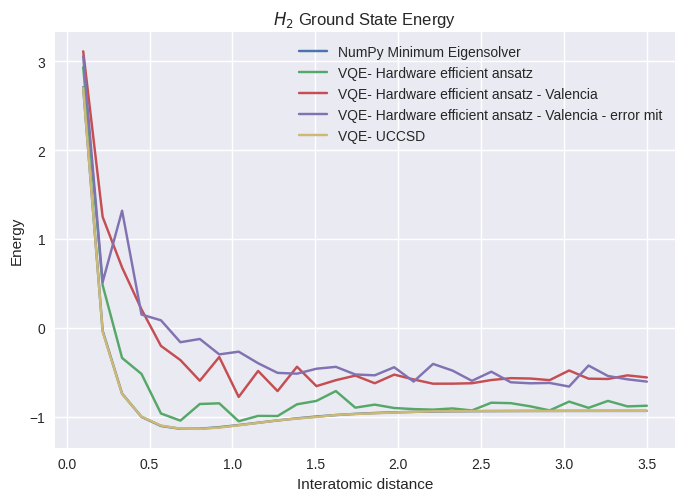

In [23]:
plt.plot(bond_lengths, exact_energies, label='NumPy Minimum Eigensolver')
plt.plot(bond_lengths, vqe_energies_effSU2, label='VQE- Hardware efficient ansatz')
plt.plot(bond_lengths, vqe_energies_effSU2_fake, label='VQE- Hardware efficient ansatz - Valencia')
plt.plot(bond_lengths, vqe_energies_effSU2_fake_mit, label='VQE- Hardware efficient ansatz - Valencia - error mit')
plt.plot(bond_lengths, vqe_energies_uccsd, label='VQE- UCCSD')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')
plt.title(r'$H_2$ Ground State Energy')
plt.legend(loc='upper right')
tikzplotlib.save("BG_ansatz_comparison.tex")

<Figure size 600x400 with 0 Axes>